In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# reference: https://github.com/sushiswap/sushiswap-subgraph
# Matic has an error

In [2]:
import CoinGeckoFunctions as cgf

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests

pd.options.mode.chained_assignment = None  # default='warn' exclude warning for chained assingments
pd.set_option('display.float_format', lambda x: '%.4f' % x) ## change float at the macro level
plt.rcParams["figure.figsize"] = (14, 6) ## change plot size at the macro level
mpl.rcParams['figure.dpi'] = 300 ## graph resolution

In [4]:
def try_(data, name):

    date = []
    volume = []
    prices = []
    balances = []

    for i in range(len(data)):

        date.append(dt.datetime.fromtimestamp(data[i]['timestamp']))
        volume.append(data[i]['volume'])
        prices.append(data[i]['prices'])
        balances.append(data[i]['balances'])

        
    df = pd.DataFrame([date, volume, prices, balances], index = ['Date/' + name, 'Volume', 'Prices', 'Balances']).T
    df = df.set_index('Date/' + name)
    
    return df

def digits(num_, dig1 = 18, dig2 = 6, int1 = 16):
    
    '''''''''
    Among USD based pools, some of the tokens have 6 digits (e.g. USDC, USDT), 
    some of the tokens have 18 digits (e.g. DAI, sUSD). To sum them up, we first need to standardize them. 
    
    Among BTC pools, some of the tokens have 8 digits some of the tokens have 18 digits. 
    
    dig1: always set at 18
    dig2: set at 6 or 8 depending whether we are working with usd pools or btc pools. 
    int1: always set at 16 when USD pools; set at 14 when BTC pools
    
    '''''''''
    
    if len(str(int(num_)))>=int1:
        num_ = num_/10**dig1 

    else:
        num_ = num_/10**dig2
        
    return num_


def try_next(data, dig1, dig2, int1):
    
    volume = []
    
    for i in range(len(data)):
        
        vol = {}
        for columns in data['Volume'][i:i+1][0]:
            vol[columns] = digits(data['Volume'][i:i+1][0][columns][0], dig1, dig2, int1)
        
        volume.append(np.sum(list(vol.values())))
            
    return  pd.Series(volume, index=data.index)


def get_pool_volume(pools, dig1, dig2, int1, pool_names, data):

    '''''''''
    dig1: always set at 18
    dig2: set at 6 or 8 depending whether we are working with usd pools or btc pools. 
    int1: always set at 16 when USD pools; set at 14 when BTC pools
    '''''''''

    df = {}
    for i in range(len(pools)):
        df[i] = try_(data[pool_names.index(pools[i])], pool_names[pool_names.index(pools[i])])

    vol = {}
    for i in range(len(df)):
        vol[i] = try_next(df[i], dig1, dig2, int1)

    volumes = pd.concat([vol[i] for i in range(len(vol))], axis = 1)
    volumes.columns = pools
    
    volumes.index = volumes.index - dt.timedelta(hours = 8) ## ADJUSTING TIME ZONE TO UTC +0 OTHERWISE HAVE PROBLEM WHEN CONVERTING CURRENCY
    

    total_volume = volumes.sum(axis = 1)
    
    return volumes, total_volume


def USD_nominate (table, coin):

    table.index = pd.to_datetime(table.index.date)
    table = table.drop_duplicates()

    table = pd.DataFrame(table, index = table.index, columns=['$USD'])

    price = cgf.get_data_start_to_end(coin, table.index[0] - dt.timedelta(90), table.index[-1] + dt.timedelta(1)) ### - 90 for safety. if data is too recent cg will give me minute data
    price.index = pd.to_datetime(price.index.date)

    table = table[table.index <=price.index[-1]]
    price = price.loc[table.index] #cleaning 

    table_usd = pd.DataFrame (table.values * price.values, columns=['$USD'], 
                              index = table.index)     
    return table_usd


def get_tricrypto2():

    url = 'https://stats.curve.fi/raw-stats-crypto/tricrypto2-1440m.json'
    r = requests.get(url)
    data = r.json()

    date = []
    volume = []
    for i in range(len(data)):
        date.append(dt.datetime.fromtimestamp(data[i]['timestamp']))

        vol0 = 0
        if '0-1' in data[i]['volume']:
            vol0 = data[i]['volume']['0-1'][0]/10**6

        vol1 = 0
        if '0-2' in data[i]['volume']:
            vol1 = data[i]['volume']['0-2'][0]/10**6

        vol2 = 0
        if '1-2' in data[i]['volume']:
            vol2 = data[i]['volume']['1-2'][0]/10**8 * data[i]['crypto_prices'][1]

        volume.append(vol0 + vol1 + vol2)

    df = pd.DataFrame([date, volume], index = ['Date', 'Volume']).T
    df = df.set_index('Date')
    df.index = df.index - dt.timedelta(hours = 8) ## To standardize

    
    return df




def get_pool_names(url_base):

    url = url_base + 'apys.json'
    r = requests.get(url)
    data = r.json()

    names = []
    dicts = []
    for name,dict_ in data['apy']['day'].items():
        names.append(name)
        dicts.append(dict_)
        
    return names

def raw_data(names, url_base):

    urls = []

    for i in range(len(names)):
        urls.append(url_base + names[i] + '-1440m.json')

    def read_data(url):
        return requests.get(url).json()

    data = {}
    for i in range(len(urls)):
        data[i] = read_data(urls[i])
        
    
    return data



def check_missing_data(chains, pool_names_internal):
    
    'If returns True there is no missing data. Our pool names are up to date. Otherwise need to update.'
    
    _pool_names = {}

    for i in range(len(chains)):
        _pool_names[i] = get_pool_names(chains[i])

    bool_ = []

    for i in range(len(_pool_names)):

        bool_.append(pool_names_internal[i] == _pool_names[i])

    return np.array(bool_).sum() == len(_pool_names)




def get_tricrypto(data, pool_names, tricrypto_label, a = 'normal'):
    
    if a == 'normal':
        dig1, dig2, dig3 = 6, 6, 8
    
    else:
        dig1, dig2, dig3 = 18, 18, 18
    
    data = data[pool_names.index(tricrypto_label)]
    
    date = []
    volume = []
    for i in range(len(data)):
        date.append(dt.datetime.fromtimestamp(data[i]['timestamp']))

        vol0 = 0
        if '0-1' in data[i]['volume']:
            vol0 = data[i]['volume']['0-1'][0]/10**dig1

        vol1 = 0
        if '0-2' in data[i]['volume']:
            vol1 = data[i]['volume']['0-2'][0]/10**dig2

        vol2 = 0
        if '1-2' in data[i]['volume']:
            vol2 = data[i]['volume']['1-2'][0]/10**dig3 * data[i]['crypto_prices'][1]

        volume.append(vol0 + vol1 + vol2)

    df = pd.DataFrame([date, volume], index = ['Date', 'Volume']).T
    df = df.set_index('Date')
    
    df.index = df.index - dt.timedelta(hours = 8) ## To standardize time zone
    df.index = pd.to_datetime(df.index.date)
    
    return df

# THIS FUNCTION NEEDS TO BE UPDATED IF THERE ARE MORE THAN USD, BTC, EUR, LINK, ETH, AND TRICRYPTO POOLS. 

In [5]:
def get_full(chain, data, columns):
    
    
    final = []
    
    if 'usd' in columns:
        
        result = get_pool_volume(pool_names[chain]['usd_pools'], 18, 6, 16, pool_names=pool_names[chain]['pools'], data = data)
        usd_stables = result[1]
        usd_stables.index = usd_stables.index.date
        usd_stables = usd_stables[~usd_stables.index.duplicated(keep='first')]
        
        usd_stables = pd.DataFrame(usd_stables, columns=['$USD'])
        
        final.append(usd_stables)
    
    if 'btc' in columns:
        
        result_btc = get_pool_volume(pool_names[chain]['btc_pools'], dig1 = 18, dig2 = 8, int1 = 14, pool_names=pool_names[chain]['pools'], data = data)
        btc_stables = USD_nominate(result_btc[1], 'bitcoin')
    
        final.append(btc_stables)
        
    if 'eur' in columns:
        
        result_eur = get_pool_volume(pool_names[chain]['eur_pools'], dig1 = 18, dig2 = 6, int1 = 16, pool_names=pool_names[chain]['pools'], data = data)
        eur_stables = USD_nominate(result_eur[1], 'stasis-eurs')
        
        final.append(eur_stables)
        
    if 'link' in columns:
        
        result_link = get_pool_volume(pool_names[chain]['link_pools'], dig1 = 18, dig2 = 6, int1 = 16, pool_names=pool_names[chain]['pools'], data = data)
        link_stables = USD_nominate(result_link[1], 'chainlink')
        
        final.append(link_stables)
        
    if 'eth' in columns:

        result_eth = get_pool_volume(pool_names[chain]['eth_pools'], dig1 = 18, dig2 = 6, int1 = 15, pool_names=pool_names[chain]['pools'], data = data)
        eth_stables = USD_nominate(result_eth[1], 'ethereum')

        final.append(eth_stables)    
        
        
    ### DUE TO THE ERROR NEED TO SET int1 = 15 for ETH pool! 

        
    if 'tricrypto' in columns:
        
        result_tricrypto = get_tricrypto(data, pool_names = pool_names[chain]['pools'], 
                                         tricrypto_label=pool_names[chain]['tricrypto'], a = pool_names[chain]['tricrypto_type'])
        
        final.append(result_tricrypto)
        
        
    agg = pd.concat([final[i] for i in range(len(final))], axis = 1)
    agg.columns = columns
    
    return agg

# Make sure that order of columns follows the order of respective pools. 

In [6]:
pool_names = {}

pool_names['ethereum'] = {'pools': ['compound', 'usdt', 'y', 'busd', 'susd', 'pax', 'ren2', 'rens',
       'hbtc', '3pool', 'gusd', 'husd', 'usdn', 'usdk', 'linkusd', 'musd',
       'rsv', 'tbtc', 'dusd', 'pbtc', 'bbtc', 'obtc', 'ust', 'eurs',
       'seth', 'aave', 'idle', 'steth', 'saave', 'ankreth', 'ib', 'link',
       'usdp', 'tusd', 'frax', 'lusd', 'busdv2', 'alusd', 'reth', 'mim',
       'eurt', 'tricrypto2'], ## HERE PUT TRICRYPTO ALWAYS AT THE END ****************
        'usd_pools': ['compound', 'usdt', 'y', 'busd', 'susd', 'pax', '3pool', 'gusd', 'husd', 'usdn', 'usdk', 'linkusd',
 'musd', 'rsv', 'dusd', 'ust','aave', 'idle',
 'saave', 'ib', 'usdp', 'tusd', 'frax', 'lusd', 'busdv2',
 'alusd', 'mim'],
        'btc_pools': ['ren2', 'rens', 'hbtc', 'tbtc', 'pbtc', 'bbtc', 'obtc'],
        'eur_pools': ['eurs', 'eurt'], 'link_pools': ['link'], 'eth_pools': ['seth', 'steth', 'reth', 'ankreth'], 
                         'tricrypto': 'tricrypto2', 'columns': ['usd', 'btc', 'eur', 'link', 'eth', 'tricrypto'],'tricrypto_type': 'normal'}

pool_names['fantom'] = {'pools': ['2pool', 'fusdt', 'ren', 'tricrypto', 'ib', 'geist'], 'usd_pools': ['2pool', 'fusdt', 'ib', 'geist'], 
                       'btc_pools': ['ren'], 'tricrypto': 'tricrypto', 'columns': ['usd', 'btc', 'tricrypto'], 'tricrypto_type': 'normal'}

pool_names['avax'] = {'pools': ['aave', 'ren', 'atricrypto'], 'usd_pools': ['aave'], 'btc_pools': ['ren'], 'tricrypto': 'atricrypto',
                     'columns': ['usd', 'btc', 'tricrypto'], 'tricrypto_type': 'a'}

pool_names['arbitrum'] = {'pools': ['2pool', 'tricrypto', 'ren'], 'usd_pools': ['2pool'], 'btc_pools': ['ren'], 'tricrypto': 'tricrypto',
                         'columns': ['usd', 'btc', 'tricrypto'], 'tricrypto_type': 'normal'}

pool_names['polygon'] = {'pools': ['aave', 'atricrypto', 'ren', 'atricrypto2', 'atricrypto3'], 'usd_pools': ['aave'], 
                         'btc_pools': ['ren'], 'tricrypto': 'atricrypto3', 'columns': ['usd', 'btc', 'tricrypto'], 'tricrypto_type': 'a'}

pool_names['xdai'] = {'pools': ['3pool'], 'usd_pools': ['3pool'], 'columns': ['usd']}



pool_names_sidechains = [pool_names['ethereum']['pools'], pool_names['fantom']['pools'], pool_names['avax']['pools'], pool_names['arbitrum']['pools'], 
                         pool_names['polygon']['pools'], pool_names['xdai']['pools']]

In [7]:
chain_list = []
for i in pool_names:
    chain_list.append(i)

# Check whether we are missing any data

In [8]:
check_accuracy = pool_names_sidechains.copy()
check_accuracy[0] = check_accuracy[0][:-1]

In [9]:
chains = ['https://stats.curve.fi/raw-stats/', 
          'https://stats.curve.fi/raw-stats-ftm/', 
          'https://stats.curve.fi/raw-stats-avalanche/',
          'https://stats.curve.fi/raw-stats-arbitrum/', 
          'https://stats.curve.fi/raw-stats-polygon/', 
          'https://stats.curve.fi/raw-stats-xdai/']

check_missing_data(chains, check_accuracy)

False

# Get raw data for all the chains

In [10]:
raw = {}

for i in range(len(chains)):
    raw[i] = raw_data(check_accuracy[i], chains[i])

# Tricrypto data for Ethereuem needs to be done separately. 

In [11]:
url = 'https://stats.curve.fi/raw-stats-crypto/tricrypto2-1440m.json'
r = requests.get(url)
data = r.json()

raw[0][len(raw[0])] = data

In [12]:
df = {}

for i in range(len(chain_list)):
    df[i] = get_full(chain_list[i], raw[i], pool_names[chain_list[i]]['columns'])
    
fin = pd.concat([df[i].sum(axis = 1) for i in range(len(df))], axis = 1)
fin.columns = chain_list

<AxesSubplot:>

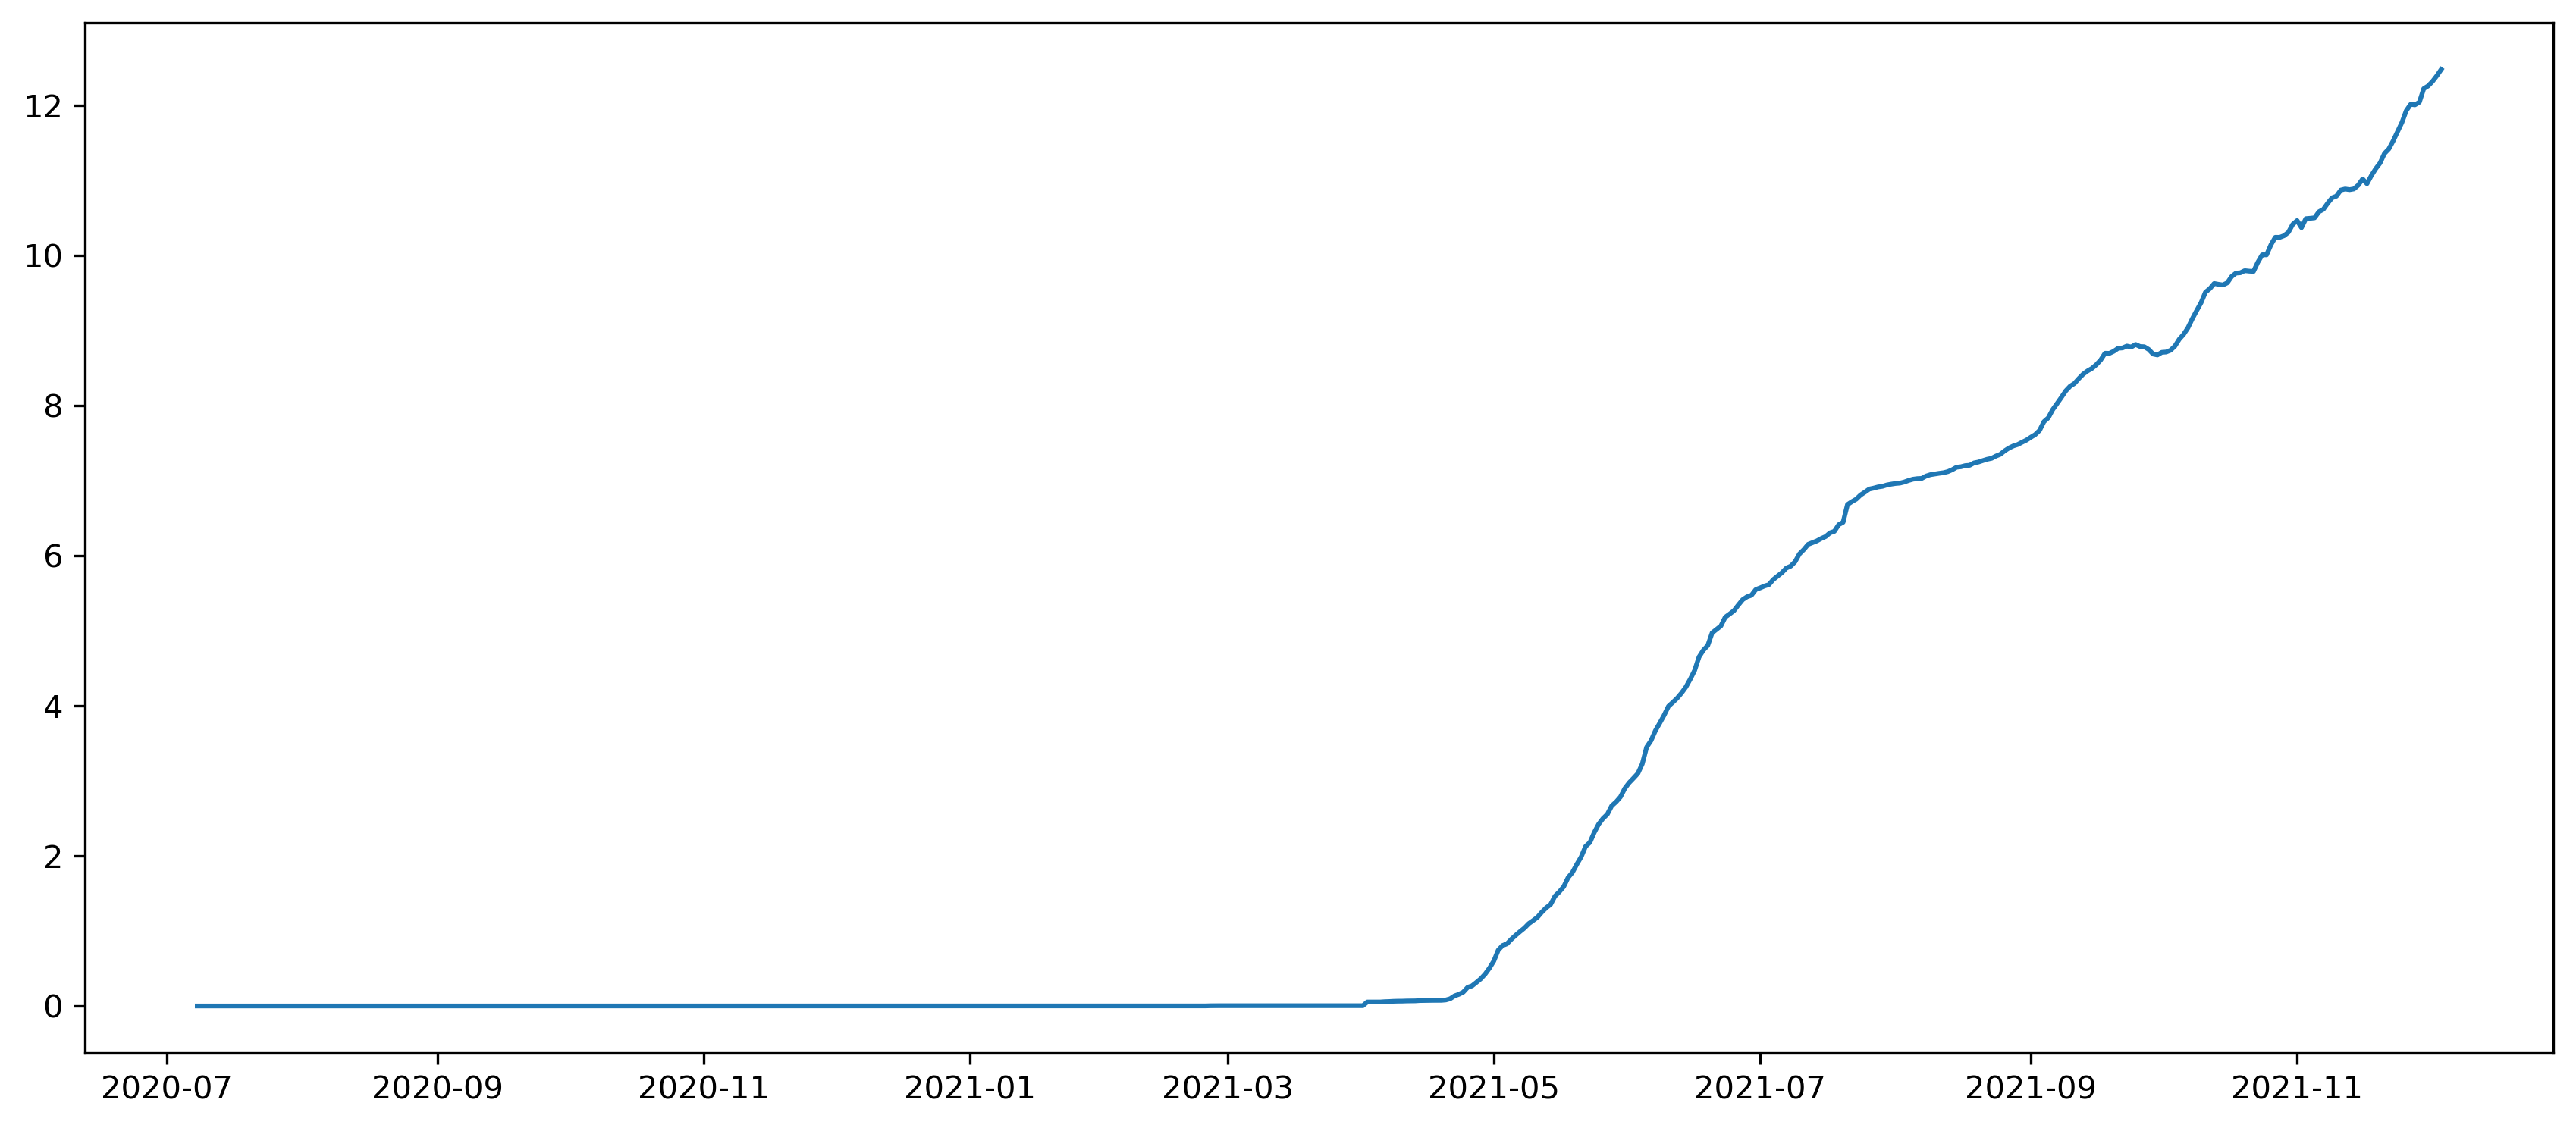

In [13]:
((fin.iloc[:, 1:].sum(axis = 1) / fin.sum(axis = 1))[:-1]*100).rolling(window=150).mean().plot()

In [27]:
fin

,ethereum,fantom,avax,arbitrum,polygon,xdai
2020-02-10,2.0002,nan,nan,nan,nan,nan
2020-02-11,19037.2308,nan,nan,nan,nan,nan
2020-02-12,208677.9267,nan,nan,nan,nan,nan
2020-02-13,399858.6942,nan,nan,nan,nan,nan
2020-02-14,1034488.4469,nan,nan,nan,nan,nan
...,...,...,...,...,...,...
2021-12-01,716214636.8054,49766368.6580,39033867.6286,7539941.6242,35802455.3476,180544.0509
2021-12-02,657398626.1710,52776527.0281,34079755.9216,6848466.0293,31517189.4753,237567.0946
2021-12-03,594739871.0876,40573669.2121,37932989.3619,9807301.7293,44838754.2727,47813.5995
2021-12-04,1110318245.7363,110767332.0546,99137115.9868,22176845.6826,75525626.8339,104552.4321


<AxesSubplot:title={'center':'Curve Daily Trading Volume in $M'}>

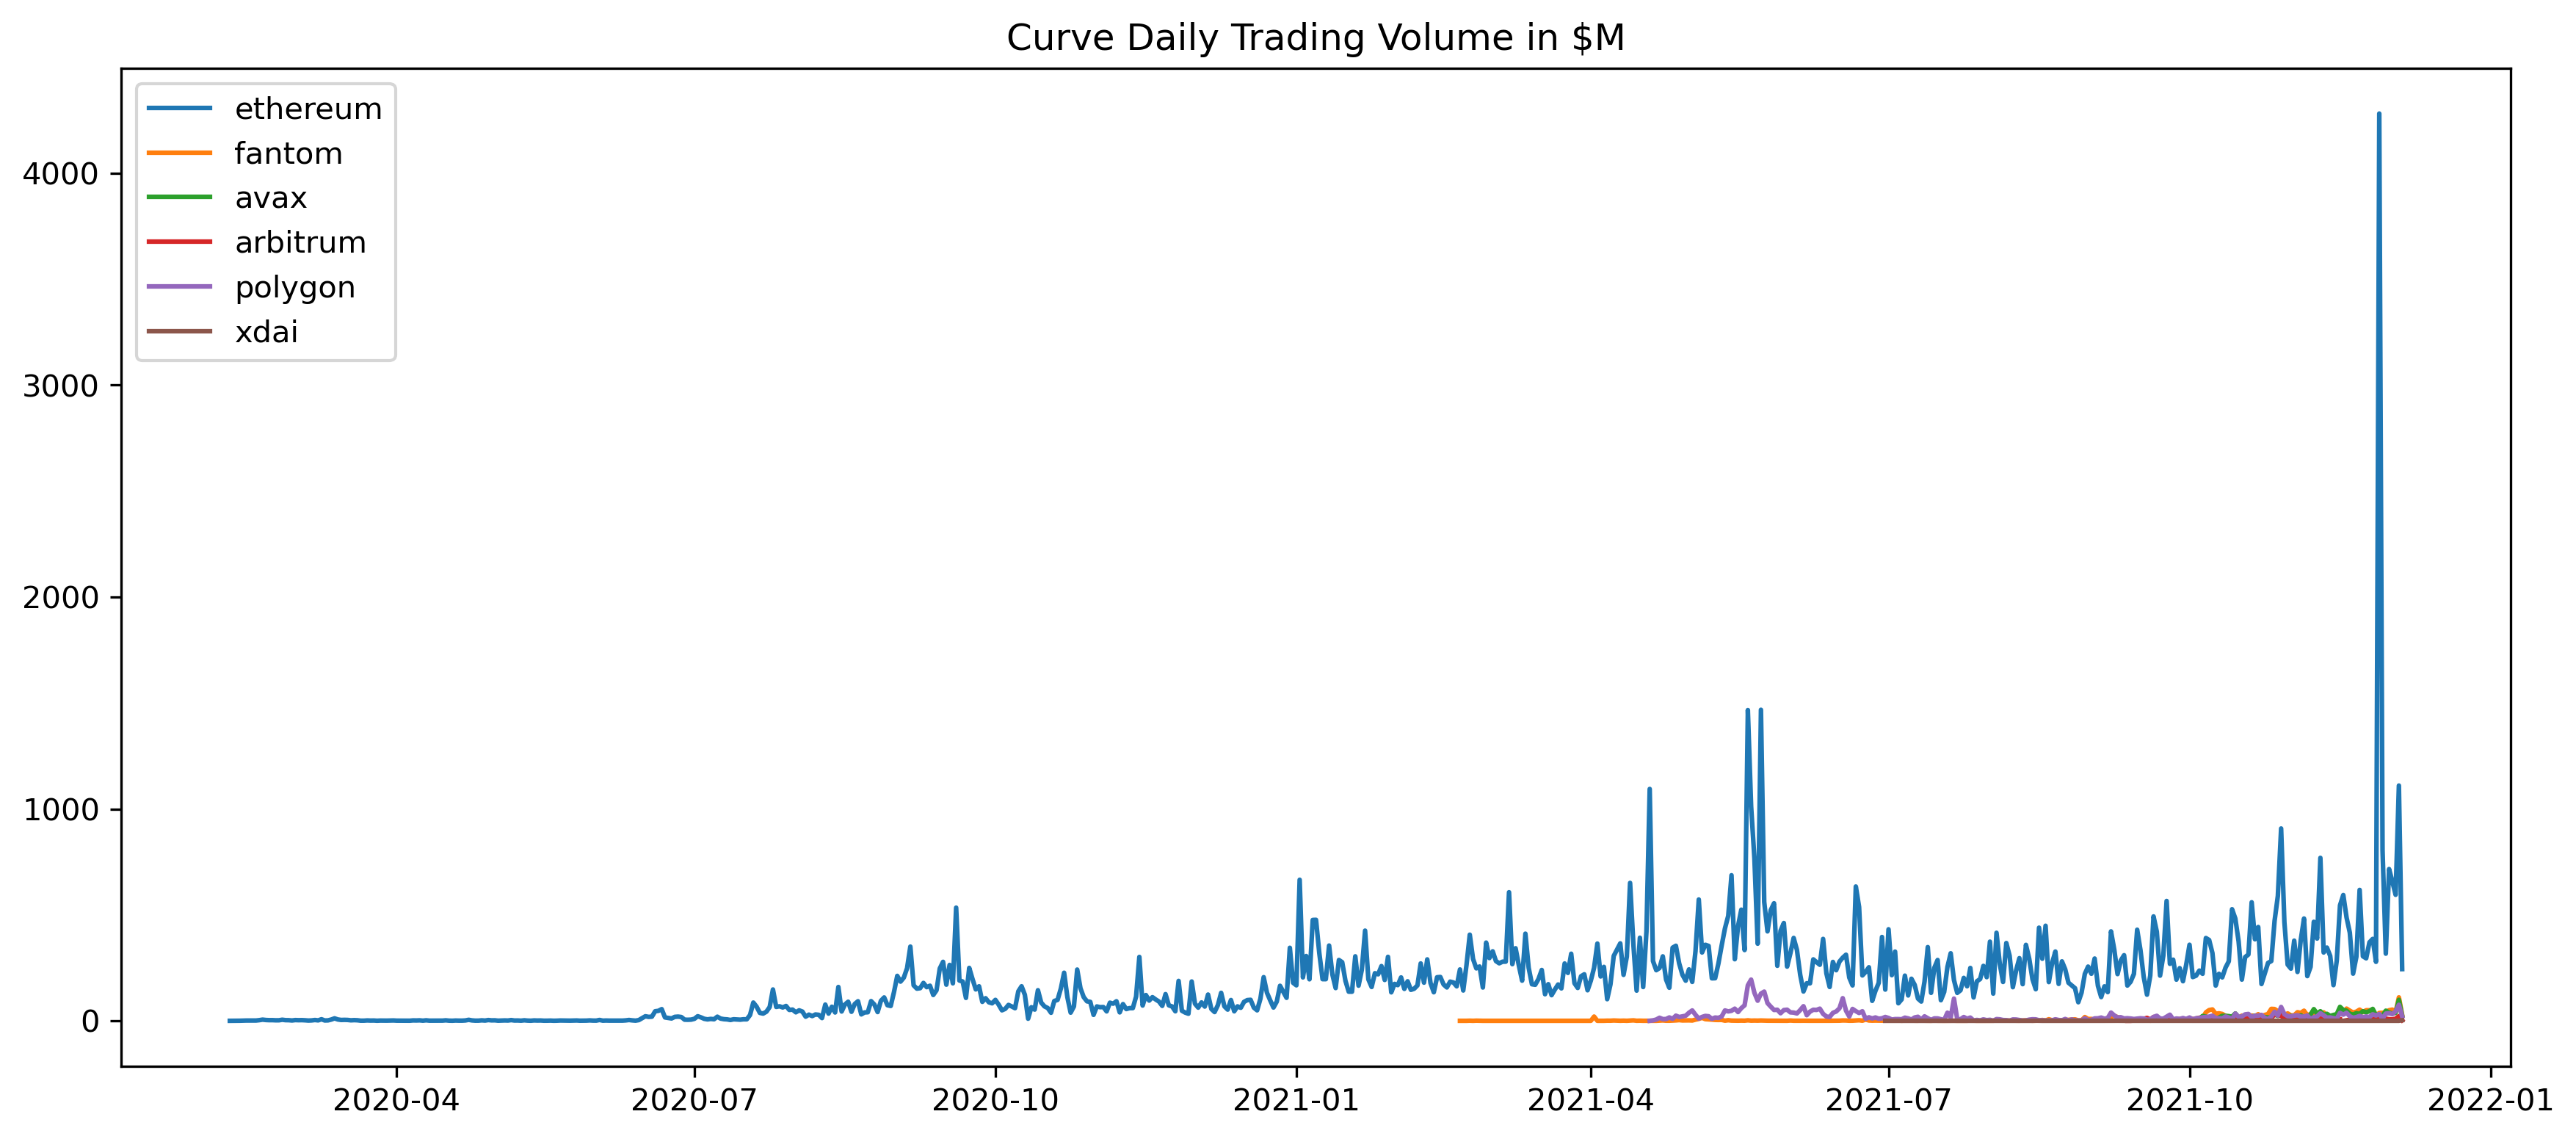

In [15]:
(fin/1000000).plot(title = 'Curve Daily Trading Volume in $M')

<AxesSubplot:title={'center':'Curve Daily Trading Volume in $M'}>

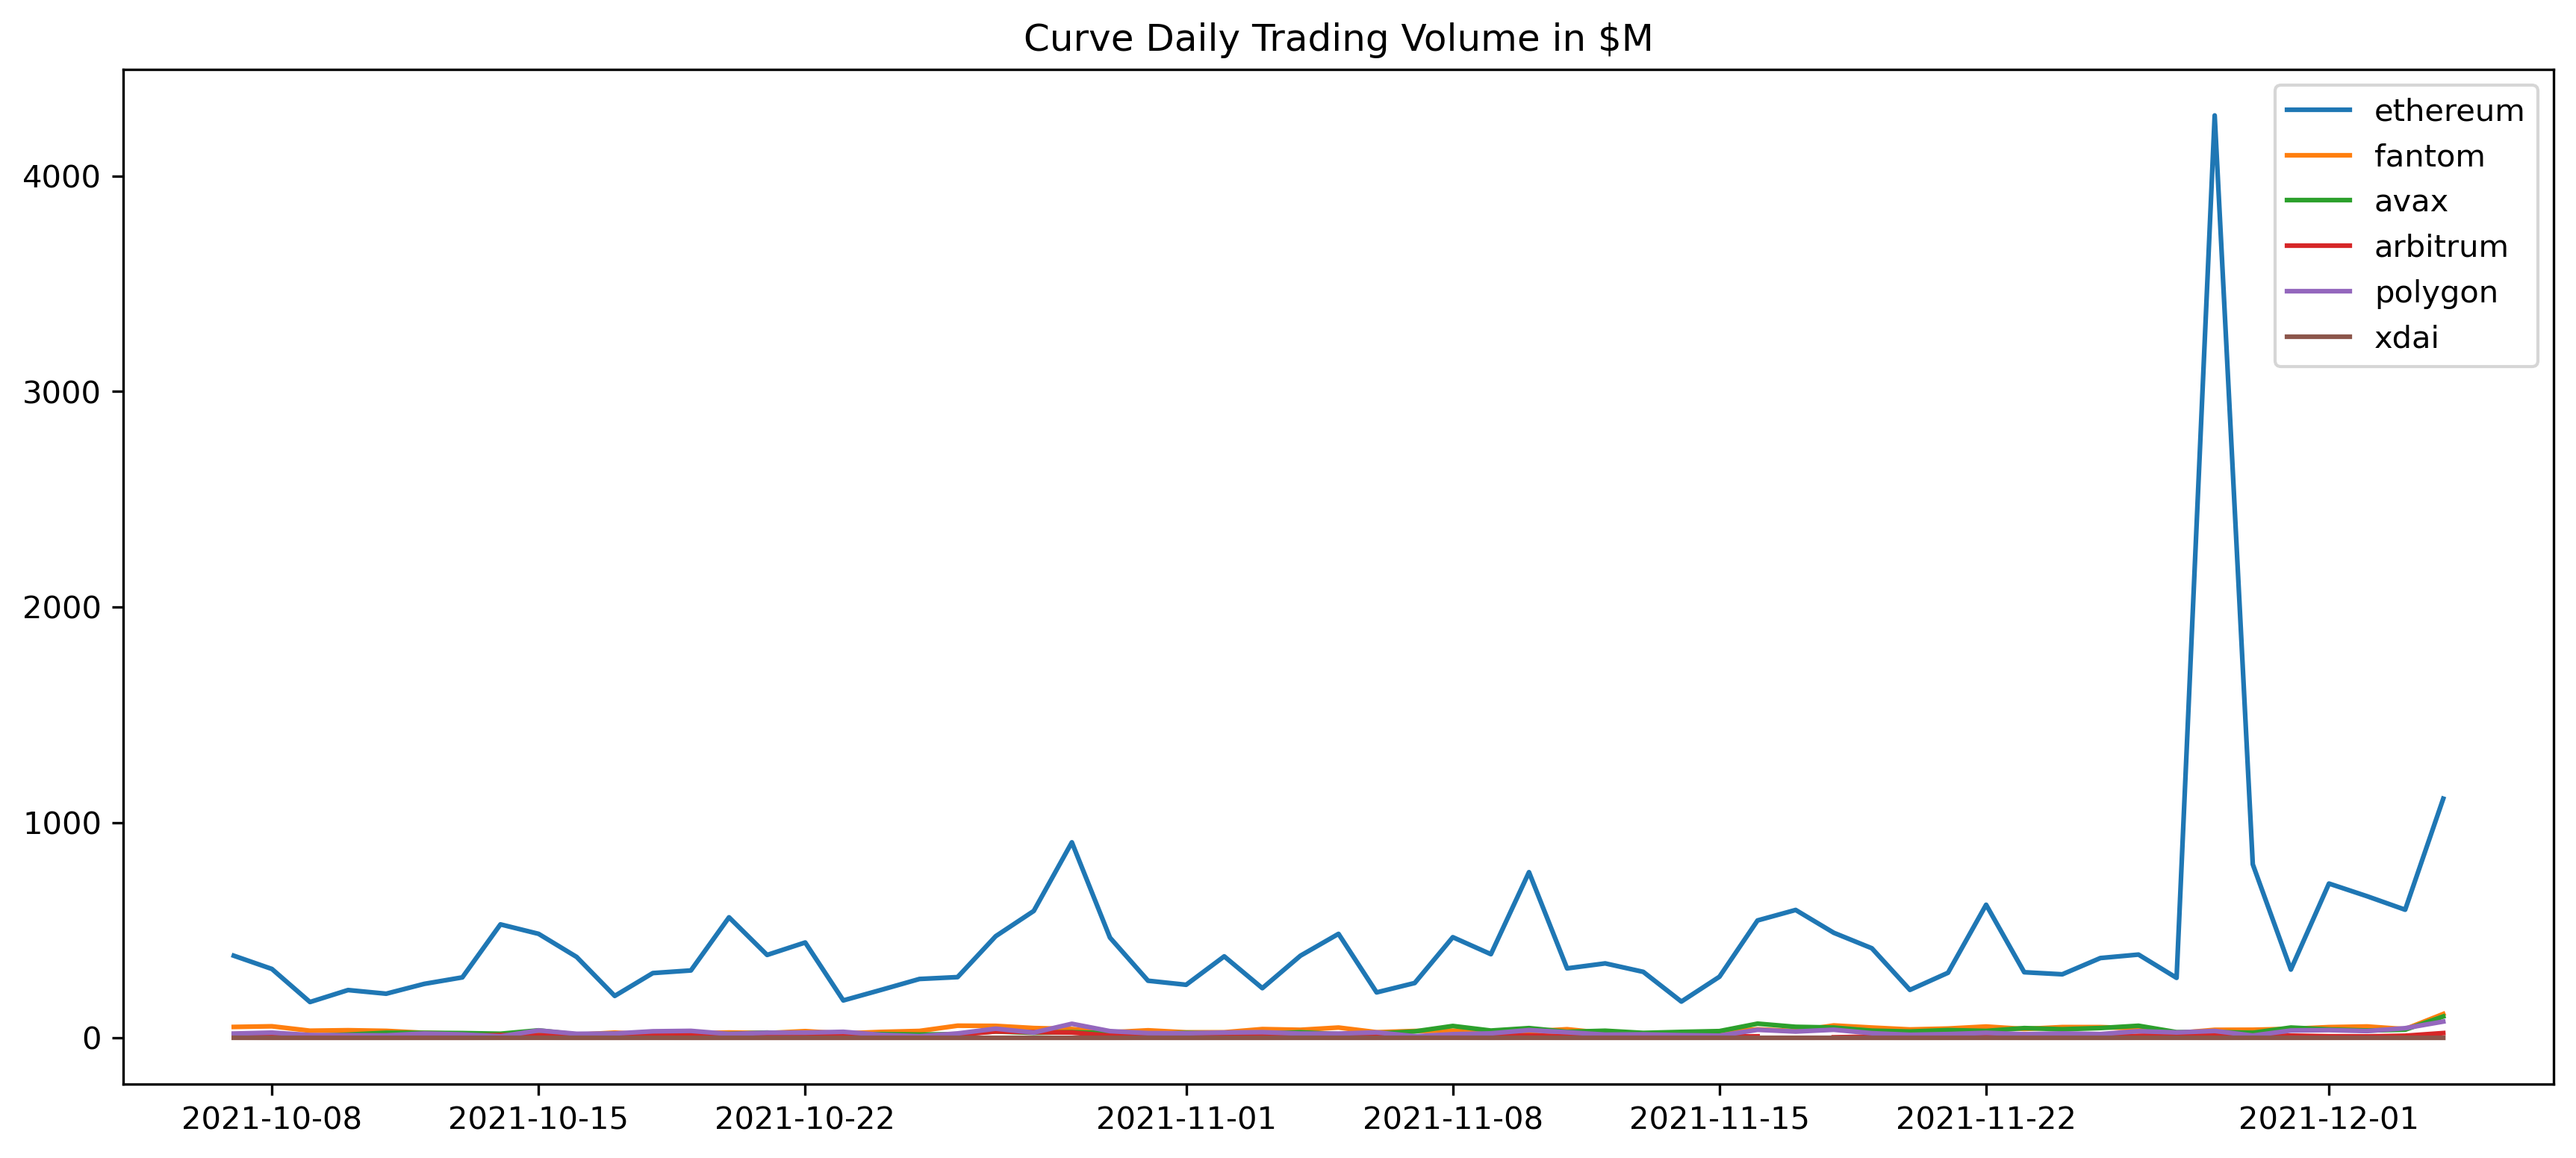

In [16]:
(fin/1000000)[-60:-1].plot(title = 'Curve Daily Trading Volume in $M')

<AxesSubplot:>

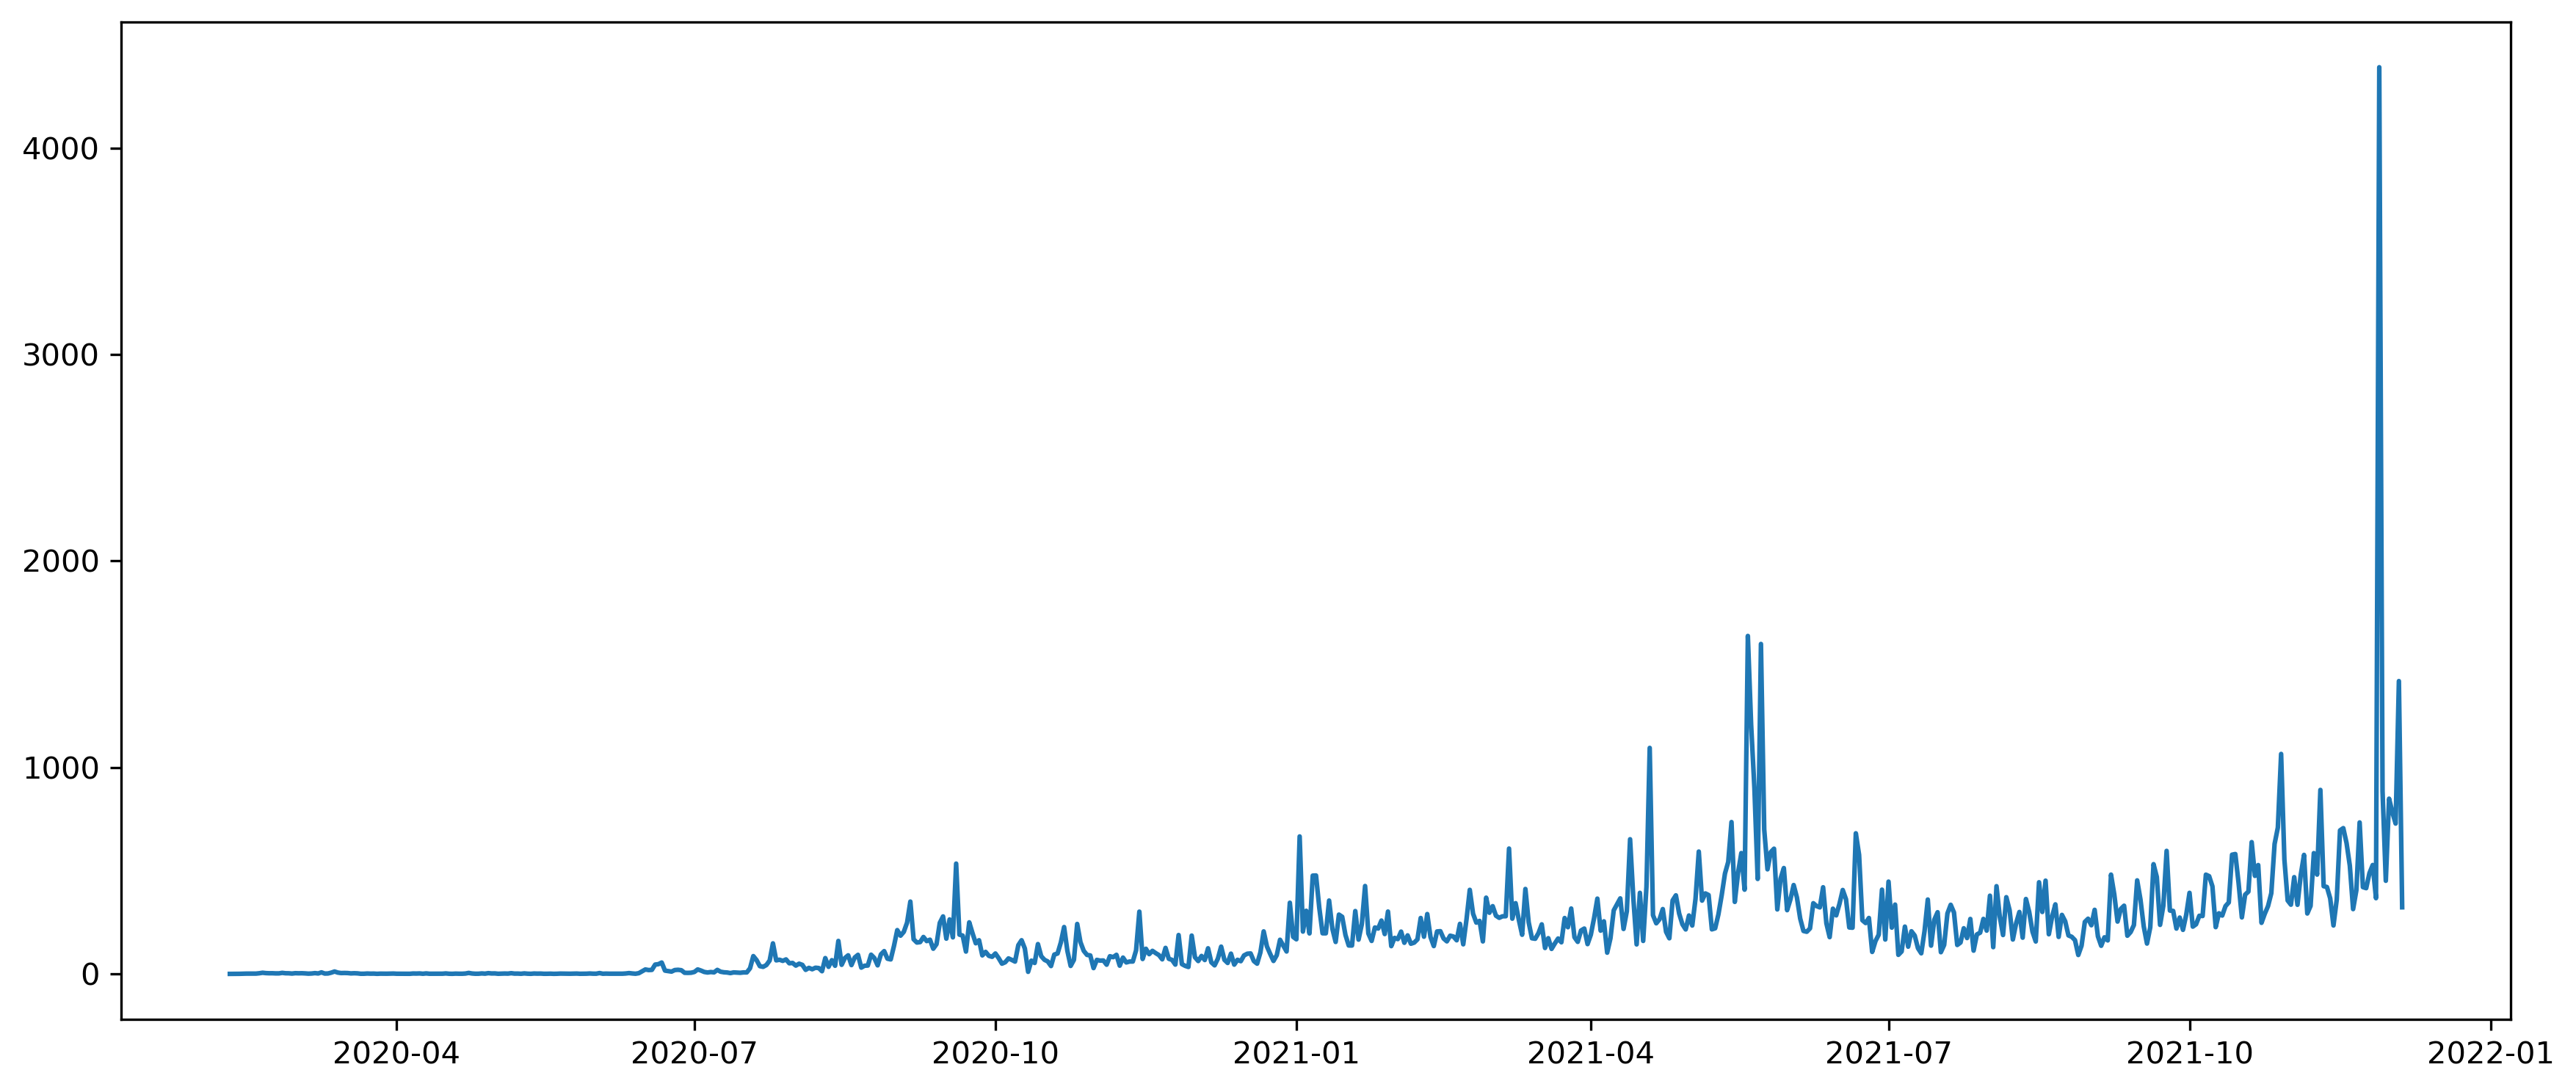

In [17]:
(fin.sum(axis = 1)/1000000).plot()

In [18]:
fin.sum(axis = 1)[-30:].mean()

681262597.2010562

<AxesSubplot:title={'center':'Daily Trading Volume in $M; 30 Day Simple Moving Average'}>

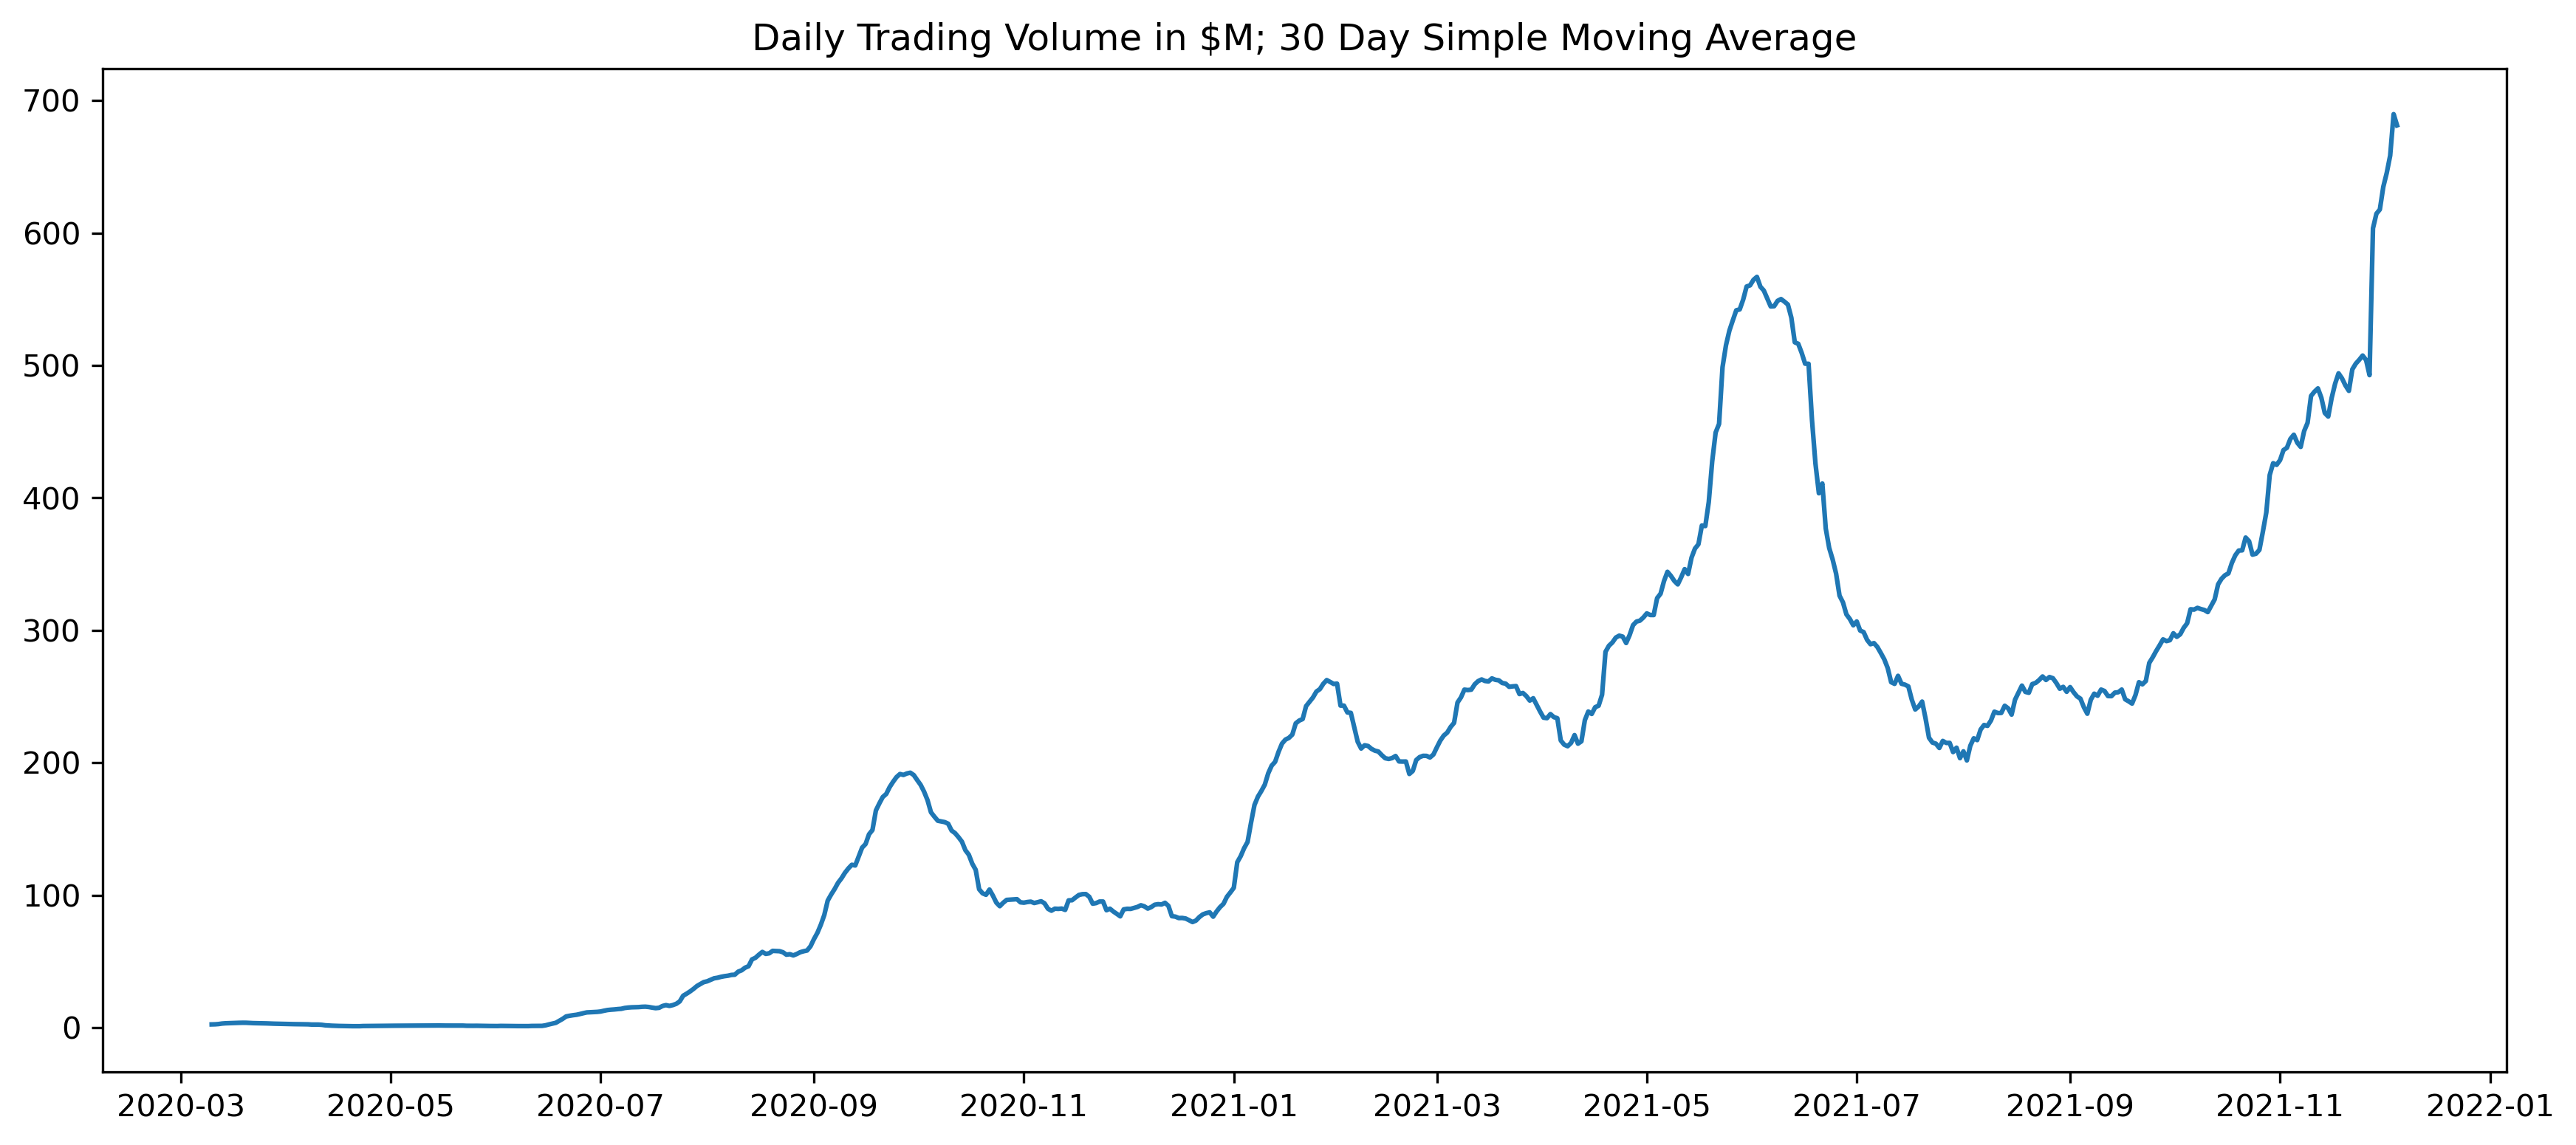

In [19]:
(fin.sum(axis = 1).rolling(window=30).mean()/1000000).plot(title = 'Daily Trading Volume in $M; 30 Day Simple Moving Average')

In [20]:
time_ = 30

xyz = (fin[:-1].iloc[:, 1:].sum(axis=1).rolling(window=time_).mean() / fin[:-1].sum(axis = 1).rolling(window=time_).mean()) * 100

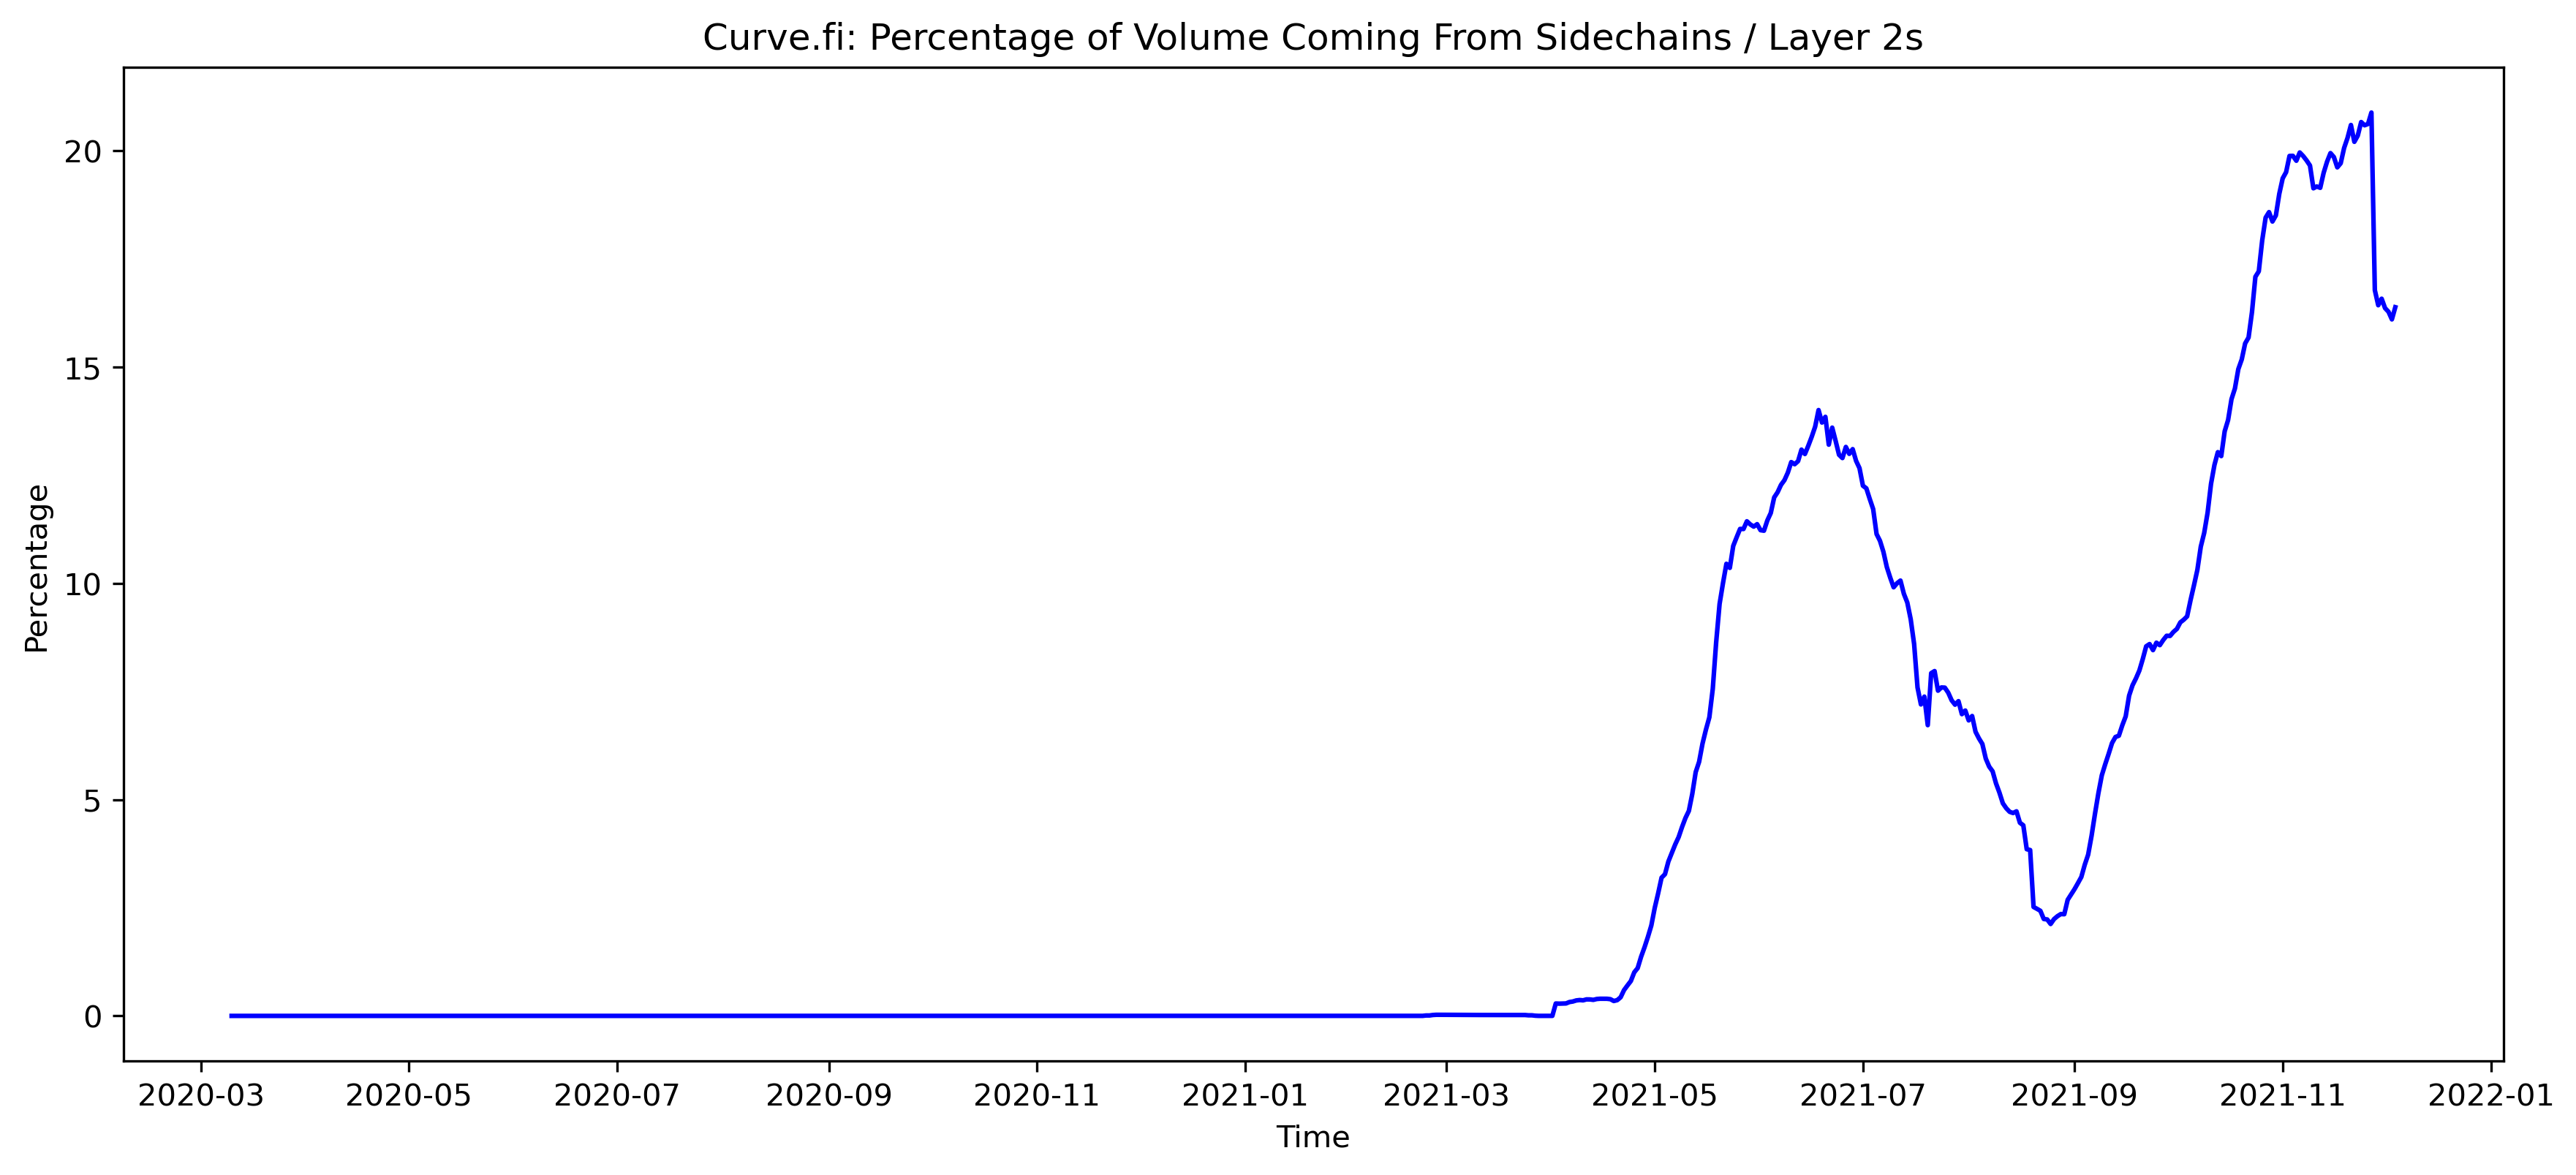

In [21]:
plt.figure()
xyz.plot(title='Curve.fi: Percentage of Volume Coming From Sidechains / Layer 2s', linestyle = 'solid', color = 'blue')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.savefig('Curve - Daily Volume Per Chain' + '.pdf')

In [22]:
total = fin.sum(axis = 1)
total = pd.DataFrame(total, columns=['Volume'])
total.index = pd.to_datetime(total.index)

monthly = total.resample('M').sum()

In [23]:
total.pct_change()

,Volume
2020-02-10,nan
2020-02-11,9516.4291
2020-02-12,9.9616
2020-02-13,0.9162
2020-02-14,1.5871
...,...
2021-12-01,0.8821
2021-12-02,-0.0774
2021-12-03,-0.0702
2021-12-04,0.9480


In [24]:
month = []
_2020 = []
_2021 = []

for i in range(2, 11):
    month.append(i)
    _2020.append(monthly[monthly.index.month == i][:1]['Volume'][0])
    _2021.append(monthly[monthly.index.month == i][-1:]['Volume'][0])

In [25]:
month_on_month = pd.DataFrame([month, _2021, _2020]).T
month_on_month.columns = ['Month', '2021', '2020']
month_on_month = month_on_month.set_index('Month')
month_on_month["Growth %"] = (month_on_month['2021'] / month_on_month['2020'] - 1) * 100

print('Average daily volume ($M) for particular month')
month_on_month.iloc[:, :2] / 30 / 1000000

Average daily volume ($M) for particular month


,2021,2020
Month,,
2.0000,195.9303,1.4249
3.0000,248.5030,2.9511
4.0000,309.6558,1.3657
5.0000,569.8585,1.2569
6.0000,303.7738,11.8759
7.0000,218.3438,34.6847
8.0000,266.1859,62.7445
9.0000,292.5225,190.6980
10.0000,437.9920,97.9013
